In [1]:
%matplotlib inline

# Version 2 du modèle prédictif

On commence par importer les données dont on aura besoin

In [2]:
import pandas as pd

In [3]:
league = pd.read_csv('data\\league.csv', index_col=0)
team = pd.read_csv('data\\team.csv', index_col=0)
match = pd.read_csv('data\\match.csv', index_col=0)

On retire les colonnes suivantes : B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA, PSH, PSD, PSA, WHH, WHD, WHA, SJH, SJD, SJA, VCH, VCD, VCA, GBH, GBD, GBA, BSH, BSD, BSA car je ne sais pas à quoi elles correspondent, il n'y a aucune indication

In [4]:
match.drop(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 
            'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], 
           axis=1, inplace=True)

Dans cette version, on ne va pas s'interesser aux joeurs, on va rester au niveau de granularité supérieur, cad les équipes

In [5]:
match.drop(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 
            'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10',
            'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 
            'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 
            'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 
            'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 
            'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 
            'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 
            'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1',
            'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 
            'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2',
            'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 
            'away_player_9', 'away_player_10', 'away_player_11'],
          axis=1, inplace=True)

On va maintenant prendre en compte la possession de balle (on ignore toujours les autres tels que corner, tirs cadrés, etc.). La colonne 'possession' est structurée comme ceci par exemple :

"
<possession>
<value>
<comment>47</comment><event_incident_typefk>352</event_incident_typefk>
<elapsed>25</elapsed>
<subtype>possession</subtype><sortorder>1</sortorder>
<awaypos>53</awaypos><homepos>47</homepos>
<n>71</n><type>special</type><id>477663</id>
</value>

<value>
<comment>51</comment><event_incident_typefk>352</event_incident_typefk>
<elapsed>45</elapsed>
<subtype>possession</subtype><sortorder>0</sortorder>
<awaypos>49</awaypos><homepos>51</homepos>
<n>65</n><type>special</type><id>477766</id>
</value>

<value>
<comment>55</comment><event_incident_typefk>352</event_incident_typefk>
<elapsed>70</elapsed>
<subtype>possession</subtype><sortorder>0</sortorder>
<awaypos>45</awaypos><homepos>55</homepos>
<n>175</n><type>special</type><id>477947</id>
</value>

<value>
<comment>57</comment><event_incident_typefk>352</event_incident_typefk>
<elapsed>90</elapsed>
<subtype>possession</subtype><sortorder>0</sortorder>
<awaypos>43</awaypos><homepos>57</homepos>
<n>172</n><type>special</type><id>478034</id>
</value>

</possession>

"

On remarque donc que les scores de possession, en pourcentages et pour chaque équipe, sont relevés la 25ème minute, la 45ème, la 70ème et à la 90ème minute. On veut la possession globale sur le match, on va donc chercher à récuperer les possessions à la 90ème minute.

Il y a cependant un problème, c'est que ces infos ne sont pas disponibles pour tous les championnats / pour toutes les années. On va donc filtrer notre dataframe sur les uniquement les lignes qui contiennent cette information.

In [6]:
match.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner'],
           axis=1, inplace=True)

On supprime toutes les lignes qui ont Na dans la colonne possession

In [7]:
match.dropna(inplace=True)
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,possession
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,1,<possession><value><comment>56</comment><event...
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,0,<possession><value><comment>65</comment><event...
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,1,<possession><value><comment>45</comment><event...
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,1,<possession><value><comment>50</comment><event...
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,2,<possession><value><comment>51</comment><event...


Certaines lignes possèdent juste la valeur '<possession />'. On va donc conserver celles qui commencent par '<possession>'

In [8]:
match = match[(match.possession.str.startswith('<possession>'))]
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,possession
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,1,<possession><value><comment>56</comment><event...
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,0,<possession><value><comment>65</comment><event...
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,1,<possession><value><comment>45</comment><event...
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,1,<possession><value><comment>50</comment><event...
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,2,<possession><value><comment>51</comment><event...


Enfin, il reste des lignes qui possède la bonne structure, mais qui en fait ne contient aucune donnée. On les supprime aussi.

In [9]:
from lxml import html

def exist_possession(row):
    tree = html.fromstring(row)
    possession = tree.xpath('//awaypos/text()')
    if len(possession) == 0:
        return False
    return True

In [10]:
match = match[match.possession.apply(exist_possession)]

On écrit maintenant la fonction qui récupère la possession de balle pour chacune des équipes, puis on supprime la colonne possession

In [11]:
def extract_away_possession(row):
    tree = html.fromstring(row)
    possession = tree.xpath('//awaypos/text()')
    return int(possession[-1])

def extract_home_possession(row):
    tree = html.fromstring(row)
    possession = tree.xpath('//homepos/text()')
    return int(possession[-1])

In [12]:
match['away_possession'] = match.possession.apply(extract_away_possession)
match['home_possession'] = match.possession.apply(extract_home_possession)
del match['possession']

In [13]:
match

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,away_possession,home_possession
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,1,45,55
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,0,34,66
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,1,54,46
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,1,48,52
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,2,48,52
1733,1734,1729,1729,2008/2009,1,2008-08-16 00:00:00,489047,8668,8655,2,3,49,51
1734,1735,1729,1729,2008/2009,1,2008-08-16 00:00:00,489048,8549,8586,2,1,47,53
1735,1736,1729,1729,2008/2009,1,2008-08-16 00:00:00,489049,8559,10194,3,1,53,47
1736,1737,1729,1729,2008/2009,1,2008-08-16 00:00:00,489050,8667,9879,2,1,47,53
1737,1738,1729,1729,2008/2009,1,2008-08-17 00:00:00,489051,8455,8462,4,0,35,65


Affichons les valeurs prises par les variables. On note que ce sont des lois normales, centrées sur environ 50 (un peu plus en home, un peu moins en away), d'écart type environ 10

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A5CACC0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000021BAB128>]], dtype=object)

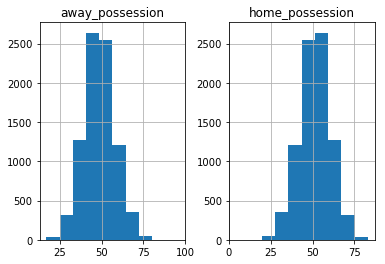

In [14]:
match[['away_possession','home_possession']].hist()

Enfin, on va supprimer les variables suivantes qui n'ont pour le moment pas d'intêret :

In [15]:
match.drop(['country_id', 'season', 'stage', 'date', 'match_api_id'],
           axis=1, inplace=True)

Enfin, on va rajouter les colonnes contenant le nom complet des équipes afin de les identifier plus facilement

In [16]:
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='home_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'home_team_long_name'}, inplace=True)
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='away_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'away_team_long_name'}, inplace=True)

In [17]:
match.drop(['team_api_id_y', 'team_api_id_x'], axis=1, inplace=True)

In [18]:
match.head()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,away_possession,home_possession,home_team_long_name,away_team_long_name
0,1729,1729,10260,10261,1,1,45,55,Manchester United,Newcastle United
1,2494,1729,10260,10261,3,0,38,62,Manchester United,Newcastle United
2,2913,1729,10260,10261,1,1,30,70,Manchester United,Newcastle United
3,3353,1729,10260,10261,4,3,47,53,Manchester United,Newcastle United
4,3693,1729,10260,10261,0,1,52,48,Manchester United,Newcastle United


Certaines équipes n'apparaissent que dans une seule des colonnes 'home' ou 'away', on supprime donc les lignes qui font intervenir une équipe 'manquante'

In [20]:
import numpy as np

In [21]:
print(len(match.home_team_long_name.unique()))
print(len(match.away_team_long_name.unique()))
print(len(np.intersect1d(match.away_team_long_name.unique(), match.home_team_long_name.unique())))

174
174
170


In [22]:
equipes_a_conserver = np.intersect1d(match.away_team_long_name.unique(), match.home_team_long_name.unique())

match = match[np.in1d(match.away_team_long_name.values, equipes_a_conserver)]
match = match[np.in1d(match.home_team_long_name.values, equipes_a_conserver)]

In [23]:
print(len(match.home_team_long_name.unique()))
print(len(match.away_team_long_name.unique()))
print(len(np.intersect1d(match.away_team_long_name.unique(), match.home_team_long_name.unique())))

167
167
166


On va maintenant se limiter à la ligue 1 française dans un premier temps

In [24]:
match_ligue_1 = match[match.league_id == 4769]
num_teams = len(match_ligue_1.away_team_api_id.unique())
print(num_teams)

23


## Construction du modèle

Maintenant que les données sont propres et identifiées, on va construire le modèle pymc3. Pour cela, il faut changer les noms des équipes en indices allant de 1 au nombre total d'équipe

In [25]:
teams = match_ligue_1.home_team_long_name.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

In [26]:
teams

,team,i
0,LOSC Lille,0
1,Toulouse FC,1
2,Olympique de Marseille,2
3,Paris Saint-Germain,3
4,Stade de Reims,4
5,SC Bastia,5
6,En Avant de Guingamp,6
7,Olympique Lyonnais,7
8,AS Monaco,8
9,Montpellier Hérault SC,9


In [27]:
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='home_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_home'}).drop('team', 1)
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='away_team_long_name', right_on='team', how='inner')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_away'}).drop('team', 1)

In [28]:
match_ligue_1.head()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,away_possession,home_possession,home_team_long_name,away_team_long_name,i_home,i_away
0,5952,4769,8639,4087,1,1,40,60,LOSC Lille,Évian Thonon Gaillard FC,0,19
1,7101,4769,8639,4087,1,0,38,62,LOSC Lille,Évian Thonon Gaillard FC,0,19
2,7377,4769,9941,4087,1,0,41,59,Toulouse FC,Évian Thonon Gaillard FC,1,19
3,7203,4769,8592,4087,1,0,37,63,Olympique de Marseille,Évian Thonon Gaillard FC,2,19
4,7186,4769,9847,4087,4,2,32,68,Paris Saint-Germain,Évian Thonon Gaillard FC,3,19


On va juste regarder si la possession de balle est corrélée au nombre de buts marqués

In [29]:
match_ligue_1.groupby(by='home_team_long_name').mean().home_possession.sort_values(ascending=False)

home_team_long_name
Paris Saint-Germain         63.769231
Olympique de Marseille      59.263158
Olympique Lyonnais          58.684211
OGC Nice                    54.631579
LOSC Lille                  54.256410
Girondins de Bordeaux       52.868421
FC Lorient                  52.473684
AS Saint-Étienne            52.184211
GFC Ajaccio                 51.368421
AS Monaco                   51.342105
Stade Rennais FC            50.763158
RC Lens                     49.842105
Toulouse FC                 49.538462
FC Nantes                   49.394737
Stade de Reims              49.184211
SC Bastia                   49.052632
Montpellier Hérault SC      49.000000
ES Troyes AC                48.368421
FC Metz                     46.684211
En Avant de Guingamp        46.263158
Angers SCO                  45.526316
Évian Thonon Gaillard FC    45.210526
SM Caen                     43.710526
Name: home_possession, dtype: float64

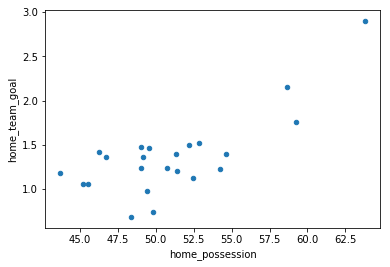

In [30]:
test = match_ligue_1.groupby(by='home_team_long_name').mean()
test[['home_possession','home_team_goal']].plot.scatter(x='home_possession', y='home_team_goal')

On split notre jeu de données (60/20/20) afin de pouvoir mesurer plus tard les perfomances des différents modèles testés. NB : on fait exprès de ne pas randomiser les individus qui iront en train/CV/test. En effet, les observations sont ordonnées dans le temps, et en application réelle, on a accès uniquement au passé pour prédire le futur.

In [31]:
# On compte le nombre d'observations dont on dispose
taille_totale = len(match_ligue_1.home_team_goal.values)
# on calcule le nombre d'observations que l'on envoie en training set
train_size = int(taille_totale*0.6)
CV_size = int(taille_totale*0.8)

observed_home_goals = match_ligue_1.home_team_goal.values[:train_size]
observed_away_goals = match_ligue_1.away_team_goal.values[:train_size]

home_team = match_ligue_1.i_home.values[:train_size]
away_team = match_ligue_1.i_away.values[:train_size]

home_possession = match_ligue_1.home_possession.values[:train_size]
away_possession = match_ligue_1.away_possession.values[:train_size]

On décrit notre modélisation. On commence par spécifier les entrées et sorties de notre modélisation

In [32]:
import theano
import numpy as np

model_input = theano.shared(np.array([home_team, away_team]))
model_output = theano.shared(np.array([observed_home_goals, observed_away_goals, home_possession, away_possession]))

Puis on écrit le modèle

In [33]:
import pymc3 as pm

model = pm.Model()
with pm.Model() as model: 
    possession = pm.Uniform("possession", lower=0, upper=100, shape=num_teams)
    
    home_possession = pm.Normal('home_possession', mu=possession[model_input[0]], sd=10, observed=model_output[2])
    away_possession = pm.Normal('away_possession', mu=possession[model_input[1]], sd=10, observed=model_output[3])

In [34]:
import pymc3 as pm

model = pm.Model()
with pm.Model() as model:   
    alpha = pm.Uniform("alpha", lower=0, upper=1)
    
    possession = pm.Uniform("possession", lower=0, upper=100, shape=num_teams)
    attaque = pm.Normal("attaque", mu=0, sd=1, shape=num_teams)
    defense = pm.Normal("defense", mu=0, sd=1, shape=num_teams)
    
    home = pm.Normal("home", mu=0, sd=1, shape=1)
    intercept = pm.Normal("intercept", mu=0, sd=1, shape=1)
    
    home_theta  = pm.math.exp(
        intercept + home + 
        attaque[model_input[0]] - defense[model_input[1]] + 
        alpha * (possession[model_input[0]] - possession[model_input[1]])
    )
    away_theta  = pm.math.exp(
        intercept + 
        attaque[model_input[1]] - defense[model_input[0]] + 
        alpha * (possession[model_input[1]] - possession[model_input[0]])
    )
    
    # sd de la possession
    eps = pm.HalfCauchy('eps', 5) 

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=model_output[0])
    away_points = pm.Poisson('away_points', mu=away_theta, observed=model_output[1])
    home_possession = pm.Normal('home_possession', mu=possession[model_input[0]], sd=eps, observed=model_output[2])
    away_possession = pm.Normal('away_possession', mu=possession[model_input[1]], sd=eps, observed=model_output[3])

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -4,667.6: 100%|███████████████████████████████████████████████| 100000/100000 [01:22<00:00, 1208.85it/s]
Finished [100%]: Average ELBO = -4,667.7
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.78it/s]


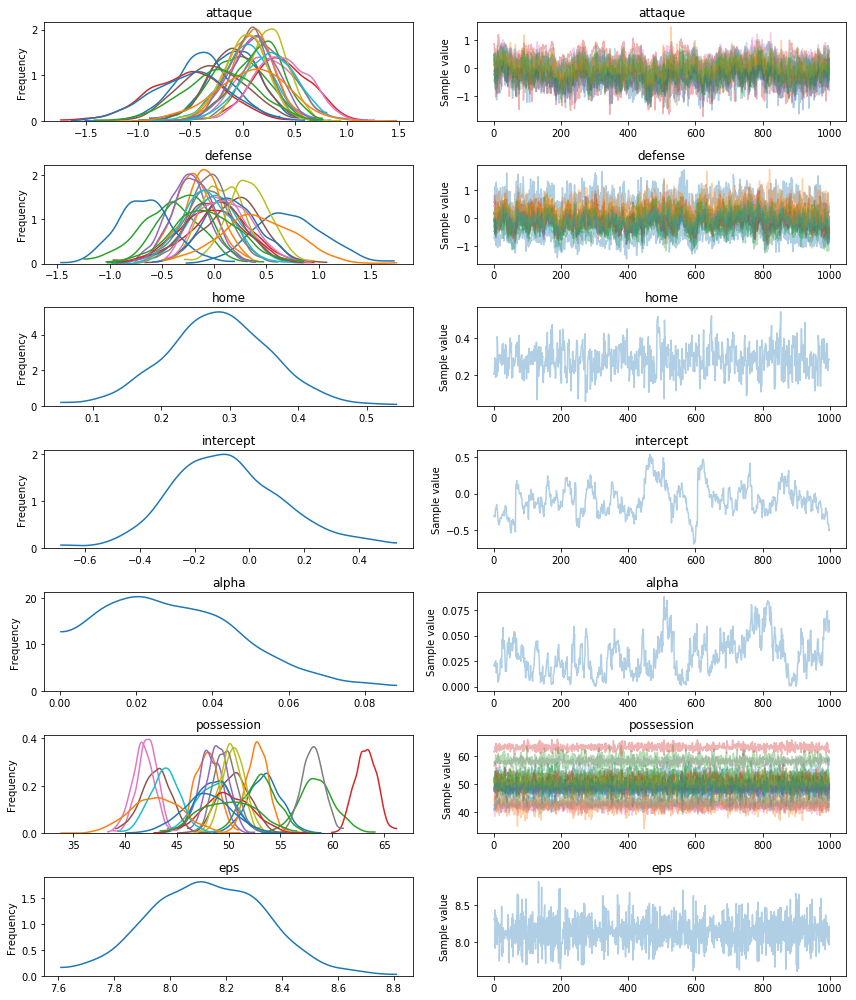

In [35]:
with model:
    trace = pm.sample(1000, n_init=100000)

    pm.traceplot(trace)

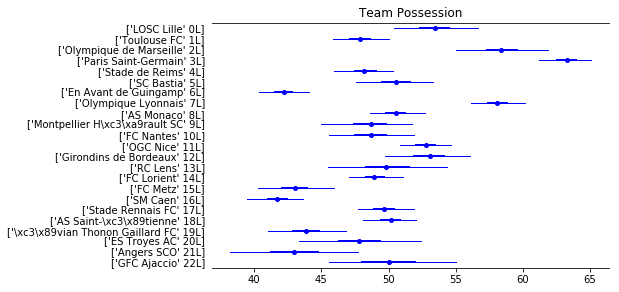

In [36]:
pm.forestplot(trace, varnames=['possession'], ylabels=teams.values, main="Team Possession", chain_spacing=0.1)

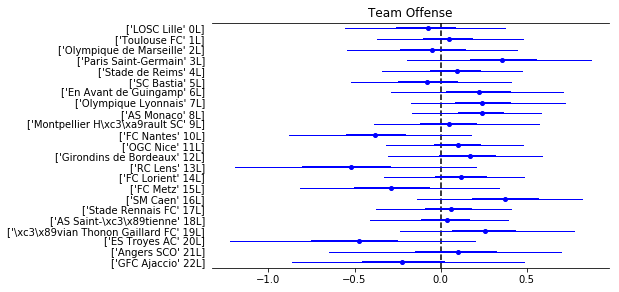

In [37]:
pm.forestplot(trace, varnames=['attaque'], ylabels=teams.values, main="Team Offense", chain_spacing=0.1)

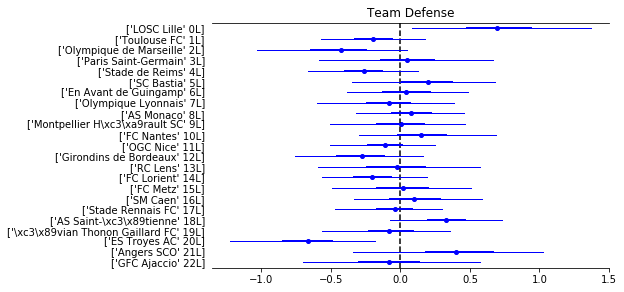

In [38]:
pm.forestplot(trace, varnames=['defense'], ylabels=teams.values, main="Team Defense", chain_spacing=0.1)

Les résultats sont cohérents, passons à la prédiction d'un nouveau match

# Prédiction de l'issue d'un match

On cherche à prédire l'issue d'un match. Pour cela, on change les paramètres d'entrée, et on relance notre modèle : (ici : PSG contre Grenoble (indice 18 vs indice 17), on s'attend à voir le PSG gagner..

In [39]:
model_input.set_value(np.array([[18],[17]]))
#model_output.set_value(np.array([[2],[0]]))

Et on sample depuis notre modèle avec les nouvelles entrées

In [40]:
ppc = pm.sample_ppc(trace[100:], model=model, samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.90it/s]


On fait un peu de mise en forme des résultats afin de pouvoir les exploiter simplement

In [41]:
away = pd.DataFrame(ppc['away_points'])
home = pd.DataFrame(ppc['home_points'])  

prediction_score = home.merge(away, how='inner', left_index=True, right_index=True)
prediction_score.columns = ['home_points', 'away_points']

In [42]:
prediction_score.head()

,home_points,away_points
0,1,0
1,0,0
2,2,1
3,1,1
4,3,0


In [43]:
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'

prediction_score['vainqueur'] = prediction_score.apply(vainqueur, axis=1)

In [44]:
prediction_score.head()

,home_points,away_points,vainqueur
0,1,0,H
1,0,0,N
2,2,1,H
3,1,1,N
4,3,0,H


In [45]:
prediction_score.vainqueur.value_counts()

H    53
N    32
A    15
Name: vainqueur, dtype: int64

On calcule les probabilités associées

In [46]:
100 * prediction_score.vainqueur.value_counts() / prediction_score.vainqueur.count()

H    53.0
N    32.0
A    15.0
Name: vainqueur, dtype: float64

On va enfin calculer le résultat le plus probable (les buts encaissés pour chacune des équipes). Une rapide visualisation nous montre que le résultat le plus probable est 2-0. Vérifions le :

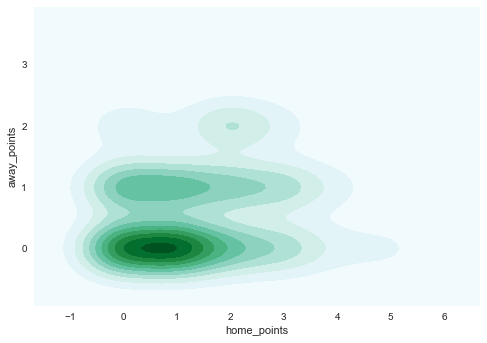

In [47]:
import seaborn
seaborn.kdeplot(data=prediction_score.home_points, data2=prediction_score.away_points, shade=True)

In [48]:
prediction_score.groupby(["home_points", "away_points"]).size()

home_points  away_points
0            0              16
             1              10
             2               3
1            0              17
             1               9
             2               1
             3               1
2            0               8
             1               7
             2               6
3            0               6
             1               6
             2               2
             3               1
4            0               2
             1               2
5            0               2
             2               1
dtype: int64

In [49]:
prediction_score.groupby(["home_points", "away_points"]).size().idxmax()

(1, 0)

In [50]:
100. * prediction_score.groupby(["home_points", "away_points"]).size().max() / prediction_score.vainqueur.count()

17.0

Conclusion, le résultat est cohérent, on s'attend à ce que le PSG l'emporte (79% de chances) avec un score de 1-0 (21 % de chances)

# Evaluation des perfomances du modèle

Maintenant que l'on a vu que notre modèle est fonctionnel (et cohérent !), nous allons dans cette dernière section évaluer notre modèle. On commence par récupérer les données de cross-validation

In [51]:
observed_home_goals = match_ligue_1.home_team_goal.values[train_size+1:CV_size]
observed_away_goals = match_ligue_1.away_team_goal.values[train_size+1:CV_size]

home_team = match_ligue_1.i_home.values[train_size+1:CV_size]
away_team = match_ligue_1.i_away.values[train_size+1:CV_size]

home_possession = match_ligue_1.home_possession.values[train_size+1:CV_size]
away_possession = match_ligue_1.away_possession.values[train_size+1:CV_size]

Et on assigne ces nouveaux individus comme entrée et sortie de notre modèle

In [52]:
model_input.set_value(np.array([home_team,away_team], dtype=np.int32))
#model_output = theano.shared(np.array([observed_home_goals, observed_away_goals]))

Et on tire 100 réalisations pour chacun des matchs

In [53]:
ppc = pm.sample_ppc(trace[100:], model=model, samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.78it/s]


On va maintenant chercher à comparer nos prédictions avec la réalité :

In [54]:
away = pd.DataFrame(ppc['away_points'])
home = pd.DataFrame(ppc['home_points'])  

On crée un dataframe pour chaque match (chacun contenant 100 simulations par exemple)

In [55]:
prediction_score = [home[[i]].merge(away[[i]], how='inner', left_index=True, right_index=True) for i in range(len(home_team))]
for df in prediction_score:
    df.columns = ['home_points', 'away_points']

Pour chaque dataframe, on détermine l'équipe qui gagne

In [56]:
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'

In [57]:
for df in prediction_score:
    df['vainqueur'] = df.apply(vainqueur, axis=1) 

On crée une liste de l'issue des matchs

In [58]:
resultats = list()
    
for df in prediction_score:
    home_score, away_score = df.groupby(["home_points", "away_points"]).size().idxmax()
    resultats.append(
        [df.vainqueur.value_counts().idxmax(), home_score, away_score]
    )
    
resultats = pd.DataFrame(np.array(resultats))
resultats.columns = ['prediction_vainqueur', 'prediction_home_score', 'prediction_away_score']

#on remet les scores au type int, sinon il sont converti en 'objet' ...
resultats[['prediction_home_score', 'prediction_away_score']] = resultats[['prediction_home_score', 'prediction_away_score']].astype(np.int32)

In [59]:
resultats

,prediction_vainqueur,prediction_home_score,prediction_away_score
0,H,1,0
1,H,0,0
2,H,1,0
3,A,0,1
4,H,1,0
5,H,1,1
6,H,2,0
7,H,4,0
8,A,1,1
9,A,0,1


On met en forme aussi les vrais résultats

In [60]:
vrai_home = pd.DataFrame(observed_home_goals)
vrai_away = pd.DataFrame(observed_away_goals)  

In [61]:
vrai_resultats = vrai_home.merge(vrai_away, how='inner', left_index=True, right_index=True)
vrai_resultats.columns = ['home_points', 'away_points']

vrai_resultats['vainqueur'] = vrai_resultats.apply(vainqueur, axis=1)

vrai_resultats = vrai_resultats.merge(resultats, how='inner', left_index=True, right_index=True)

In [62]:
vrai_resultats

,home_points,away_points,vainqueur,prediction_vainqueur,prediction_home_score,prediction_away_score
0,2,0,H,H,1,0
1,0,0,N,H,0,0
2,2,1,H,H,1,0
3,4,0,H,A,0,1
4,3,1,H,H,1,0
5,0,0,N,H,1,1
6,3,0,H,H,2,0
7,2,2,N,H,4,0
8,1,0,H,A,1,1
9,4,1,H,A,0,1


On calcule notre score

In [63]:
np.sum(vrai_resultats.vainqueur.values == vrai_resultats.prediction_vainqueur.values) / float(len(home_team))

0.46710526315789475

In [64]:
from sklearn import metrics

In [65]:
metrics.confusion_matrix(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values,labels=['A','H','N'])

array([[12, 25,  1],
       [ 6, 57,  2],
       [ 6, 41,  2]])

Confusion matrix, without normalization
[[12 25  1]
 [ 6 57  2]
 [ 6 41  2]]
Normalized confusion matrix
[[ 0.32  0.66  0.03]
 [ 0.09  0.88  0.03]
 [ 0.12  0.84  0.04]]


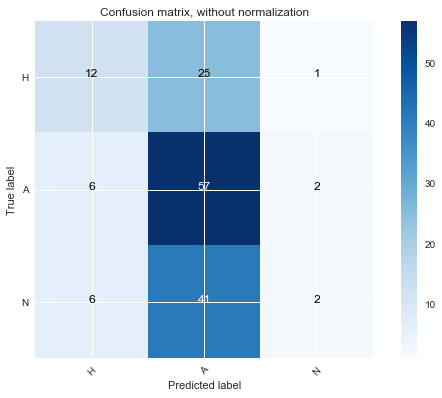

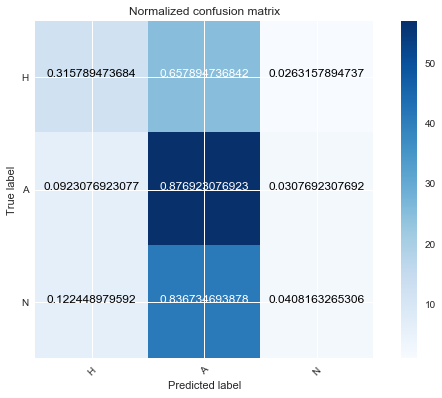

In [66]:
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

class_names = ['H','A','N']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [67]:
metrics.accuracy_score(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values)

0.46710526315789475

In [68]:
print(metrics.classification_report(vrai_resultats.vainqueur.values, vrai_resultats.prediction_vainqueur.values))

             precision    recall  f1-score   support

          A       0.50      0.32      0.39        38
          H       0.46      0.88      0.61        65
          N       0.40      0.04      0.07        49

avg / total       0.45      0.47      0.38       152



Commentaires :
- Les résultats sont encourageant pour un modèle aussi simple (quasiment 50% de réussite, à comparer aux 33% d'une méthode complètement aléatoire)
- On prédit trop souvent Away : peut être que le modèle favorise trop l'équipe à domicile...

In [69]:
vrai_resultats.vainqueur.value_counts() / vrai_resultats.vainqueur.count()

H    0.427632
N    0.322368
A    0.250000
Name: vainqueur, dtype: float64

prochaine étapes :
- améliorer le modèle hierarchique (prendre en compte les tirs cadrés, etc.)
- modéliser au niveau de chaque joueur ?
- écrire le code d'une simulation d'une saison entière pour obtenir le classement final

Enfin, on va compter le nombre de fois où notre projection de score est correcte

In [70]:
score_juste = vrai_resultats[vrai_resultats.home_points == vrai_resultats.prediction_home_score]
score_juste = score_juste[vrai_resultats.away_points == vrai_resultats.prediction_away_score]
len(score_juste) / float(len(vrai_resultats))

C:\Users\Alexis\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


0.1118421052631579

On a prédit le bon score dans 12,5% des cas.

In [71]:
score_juste

,home_points,away_points,vainqueur,prediction_vainqueur,prediction_home_score,prediction_away_score
1,0,0,N,H,0,0
12,0,1,A,A,0,1
13,2,1,H,A,2,1
19,0,1,A,A,0,1
31,1,1,N,H,1,1
42,0,0,N,H,0,0
76,1,0,H,A,1,0
79,1,1,N,H,1,1
83,1,1,N,H,1,1
88,1,1,N,H,1,1


A l'avenir, utiliser pymc3.stats.compare(traces, models, ic='WAIC') pour comparer les modèles